In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
# import mglearn   # additional library for plots bulding

from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# from scipy import stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Read and Analize datasets**

In [ ]:
# Read the dataset
file_path = '/content/drive/MyDrive/Datasets/data_auction_verification.csv'
df = pd.read_csv(file_path)
df.head()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889
3,0,0,2,1,59,6,0,False,108.640000
4,0,0,2,1,60,1,0,True,85.466667


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


Всього 2043 спостережень, пропущених значень не має.

In [ ]:
df.describe(include='all')

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043,2043.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1781,NaN
mean,1.000000,2.093979,1.883994,0.587861,71.473324,3.252080,0.455213,NaN,7336.944574
std,0.816696,0.811269,0.320310,0.492340,8.048740,1.804225,1.062828,NaN,10375.393650
min,0.000000,0.000000,1.000000,0.000000,59.000000,1.000000,0.000000,NaN,77.916667
25%,0.000000,1.000000,2.000000,0.000000,65.000000,2.000000,0.000000,NaN,546.818910
50%,1.000000,2.000000,2.000000,1.000000,70.000000,3.000000,0.000000,NaN,1316.983333
75%,2.000000,3.000000,2.000000,1.000000,78.000000,5.000000,0.000000,NaN,10876.638889


In [ ]:
# Generate a correlation matrix and visualize possible correlations between all numerical columns
correlation_matrix_1 = df.corr()   # df[cols_num].corr()
mask1 = np.triu(correlation_matrix_1)

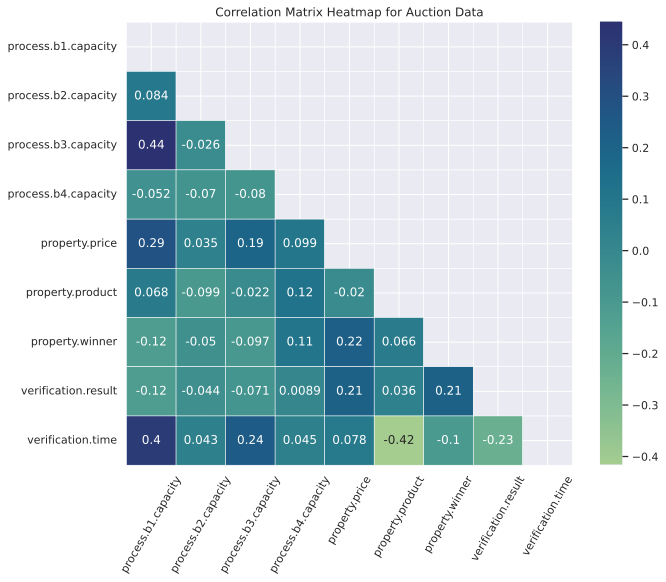

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_1, annot=True, cmap='crest', linewidths=0.5, mask=mask1)
plt.title('Correlation Matrix Heatmap for Auction Data')
plt.xticks(rotation=60)
plt.show()

Для класифікації будемо використовувати як таргет **'verification_result'**. Спостерігаємо гарну позитивну кореляцію з признаками **'property.price'**, **'property.winner'**, та негативну кореляцію з **'process.b1.capacity'**

In [ ]:
# Some of feature has a nature of categorical featuresbecause they are
# discrete and limited values.
cols_cat = ['process.b1.capacity', 'process.b2.capacity', 'process.b3.capacity',
       'process.b4.capacity', 'property.product',
       'property.winner', 'verification.result']
cols_continues = ['property.price', 'verification.time']

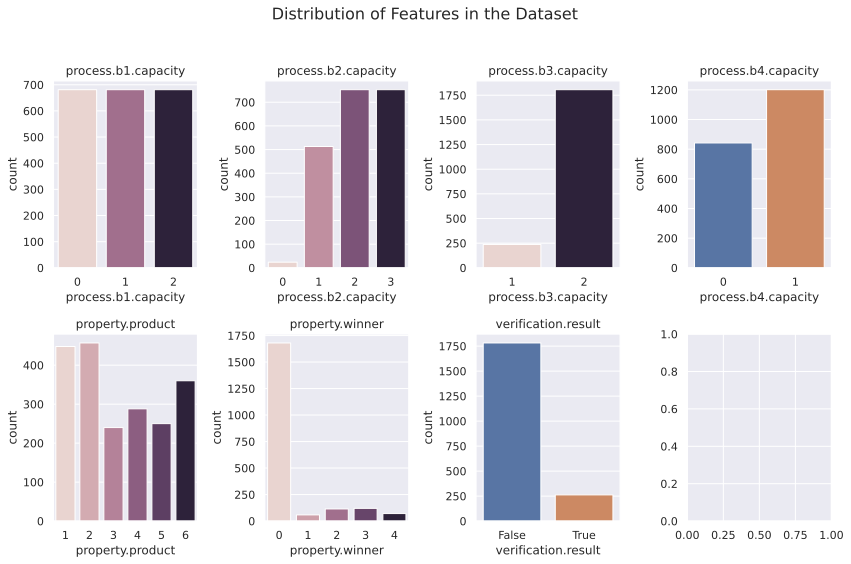

In [ ]:
# Visualize distribution of categorical features
# including the target - auction verified (1) or not(0)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
fig.suptitle('Distribution of Features in the Dataset', fontsize=16)

# Generate box plots for each column
for i, col in enumerate(cols_cat):
    sns.countplot(x=col, hue=col, stat='count', data=df, legend=False, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show();

Бачимо розподіл значень окремих признаків - великий дізбаланс значень в '**property.winner'** і головне дізбаланс в нашому таргету **'verificiation_result'**, - це означає що наша модель буде краще знаходити невдалі аукціони, тому що в моделі буде більше інформації про їх різноманіття.   

In [ ]:
# Let's visualize correlation between all features
sns.pairplot(df.sample(frac=0.2, random_state=42), corner=True, kind='reg', diag_kind='kde');

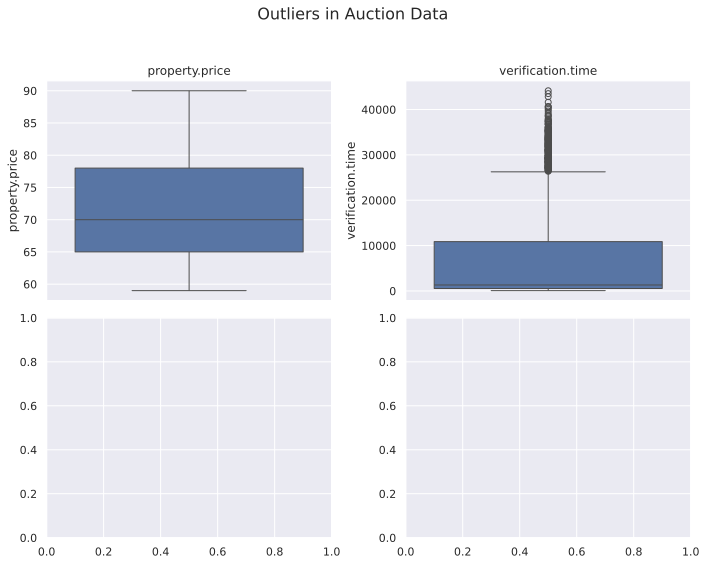

In [ ]:
# Let's check whether the continues features have outliers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.suptitle('Outliers in Auction Data', fontsize=16)

# Generate box plots for each column
for i, col in enumerate(cols_continues):
    sns.boxplot(y=df[col], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**'verification.time'** має викиди по верхньомк рівню. З попереднього графіку бачимо що цей признак має кореляцію з таргетом. Можна спробувати поекспериментувати з видаленням ціх викидів

## **2. Clean Data and Feature Engineering**

### 2.1. Create new features

In [ ]:
# Create new features
df['total.capacity'] = df[['process.b1.capacity', 'process.b2.capacity', 'process.b3.capacity', 'process.b4.capacity']].sum(axis=1)
df['price.capacity.unit'] = df['property.price'] / df['total.capacity'].replace(0, 1)

In [ ]:
# Check whether new features has good correlation with the target
correlation_matrix_2 = df.corr()
mask2 = np.triu(correlation_matrix_2)

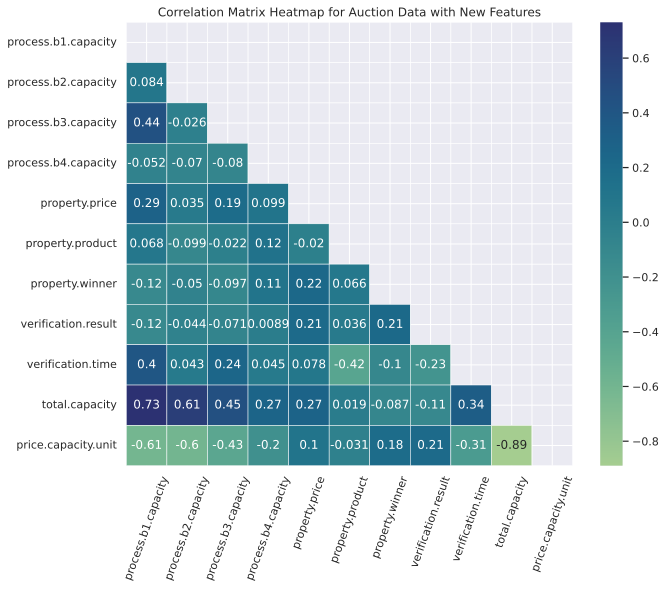

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_2, annot=True, cmap='crest', linewidths=0.5, mask=mask2)
plt.title('Correlation Matrix Heatmap for Auction Data with New Features')
plt.xticks(rotation=70)
plt.show()

**'price.capacity.unit'** має добру позитивну кореляцію з таргетом - може бути корисне, а **'total.capacity'** має слабку негативну кореляцію тому невпевнений що це додасть якості.

In [ ]:
# Update columns with new continue values
for n in df.columns[9:]:
  cols_continues.append(n)

### 2.2. Scale values

In [ ]:
# Separate target
X = df.drop('verification.result', axis=1)
y = df['verification.result']

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### 2.3. Split train/val/test

In [ ]:
# Split data 70/20/10 - If we split to 80/20 the metrics will be better
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)

### 2.4. Visualization of Metrics

In [ ]:
def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    classes = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score']

    # Write data on class, metric and values
    data = []
    for cls in classes:
        for metric in metrics:
            data.append((cls, metric, report[cls][metric]))

    # Create new dataset for the report
    df = pd.DataFrame(data, columns=['class', 'metric', 'value'])

    # Plot result
    plt.figure(figsize=(10, 6))
    sns.barplot(x='class', y='value', hue='metric', data=df)
    plt.title(title)
    plt.show()

## **3. Build Bagging Model**

### 3.1. Default RandomForest Model

In [ ]:
# Initialize classifier
clf_rf = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)   # default parameters

In [ ]:
# Fit default model
clf_rf.fit(X_train, y_train)
y_val_pred_1 = clf_rf.predict(X_val)

val_report_1 = classification_report(y_val, y_val_pred_1, digits=3)

y_test_pred_1 = clf_rf.predict(X_test)
test_report_1 = classification_report(y_test, y_test_pred_1, digits=3)

print("Validation Report:\n", val_report_1)
print("Test Report:\n", test_report_1)

Validation Report:
               precision    recall  f1-score   support

       False      0.997     0.997     0.997       355
        True      0.981     0.981     0.981        53

    accuracy                          0.995       408
   macro avg      0.989     0.989     0.989       408
weighted avg      0.995     0.995     0.995       408

Test Report:
               precision    recall  f1-score   support

       False      0.994     1.000     0.997       179
        True      1.000     0.962     0.980        26

    accuracy                          0.995       205
   macro avg      0.997     0.981     0.989       205
weighted avg      0.995     0.995     0.995       205



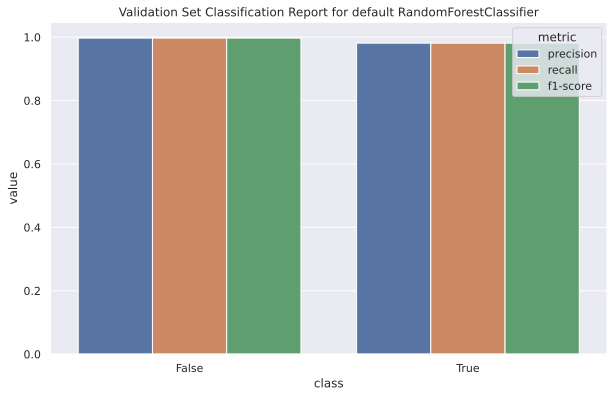

In [ ]:
plot_classification_report(y_val, y_val_pred_1, 'Validation Set Classification Report for default RandomForestClassifier')

Дефолтна модель показала гарні метрики (**F1-score = 0.989**) на валідаційному та на тестовому сеті. Як ми і передбачували модель краще знаходить класс "**False**"

### 3.2. RandomForest Model with tuned hiperparameters

In [ ]:
# Params for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize classifier
clf_rf_tuned = RandomForestClassifier(random_state=42)

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_rf_tuned, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit classification model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Evaluate the best model on the val and test sets
best_clf_rf_tuned = grid_search.best_estimator_
y_val_pred_2 = best_clf_rf_tuned.predict(X_val)
val_report_2 = classification_report(y_val, y_val_pred_2, digits=3)

y_test_pred_2 = best_clf_rf_tuned.predict(X_test)
test_report_2 = classification_report(y_test, y_test_pred_2, digits=3)

print("Best Parameters:\n", best_params)
print("Validation Report:\n", val_report_2)
print("Test Report:\n", test_report_2)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters:
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Validation Report:
               precision    recall  f1-score   support

       False      0.997     0.997     0.997       355
        True      0.981     0.981     0.981        53

    accuracy                          0.995       408
   macro avg      0.989     0.989     0.989       408
weighted avg      0.995     0.995     0.995       408

Test Report:
               precision    recall  f1-score   support

       False      0.994     1.000     0.997       179
        True      1.000     0.962     0.980        26

    accuracy                          0.995       205
   macro avg      0.997     0.981     0.989       205
weighted avg      0.995     0.995     0.995       205



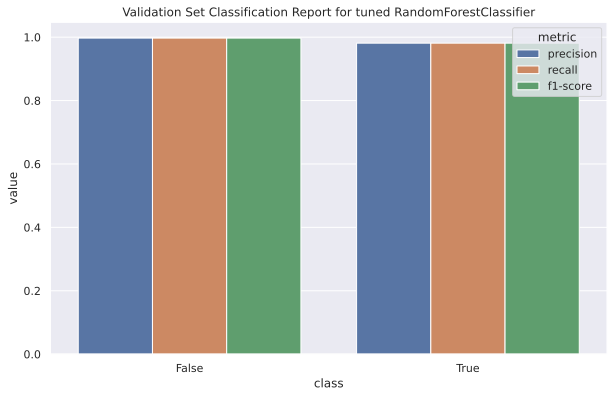

In [ ]:
plot_classification_report(y_val, y_val_pred_2, 'Validation Set Classification Report for tuned RandomForestClassifier')

Навіть з підбором гіперпараметрів нам не вдалось покращити метрики моделі. Це очікувано, по класу "**False**" в нас вже гарний результат, а по класу "**True**" в нас просто мало даних для якісного тренування моделі.

### 3.3. Show Feature Importances of the Model

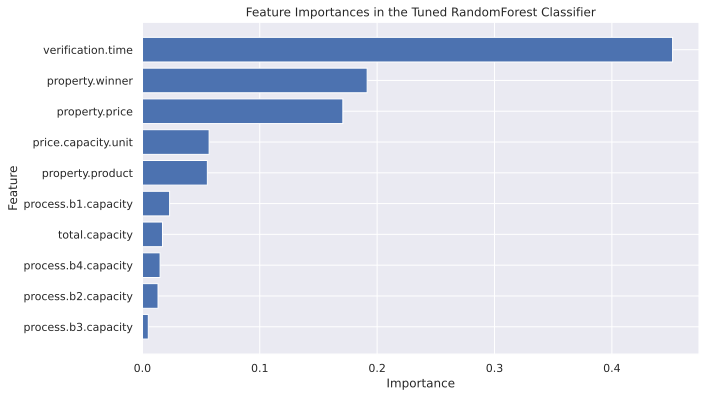

In [ ]:
importance = best_clf_rf_tuned.feature_importances_
feature_names = X.columns

# Create pandas frame for visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in the Tuned RandomForest Classifier')
plt.gca().invert_yaxis()
plt.show()

## **4. Build Boosting Model**

### 4.1. Default XGBoost Model

In [ ]:
# Initialize XGBoost classifier
cls_xgb = XGBClassifier(random_state=42) #, use_label_encoder=False, eval_metric='logloss')

# Train the model
cls_xgb.fit(X_train, y_train)

# Make predictions
y_val_pred_3 = cls_xgb.predict(X_val)

In [ ]:
val_report_3 = classification_report(y_val, y_val_pred_3, digits=3)

y_test_pred_3 = cls_xgb.predict(X_test)
test_report_3 = classification_report(y_test, y_test_pred_3, digits=3)

print("Validation Report:\n", val_report_3)
print("Test Report:\n", test_report_3)

Validation Report:
               precision    recall  f1-score   support

       False      0.997     1.000     0.999       355
        True      1.000     0.981     0.990        53

    accuracy                          0.998       408
   macro avg      0.999     0.991     0.995       408
weighted avg      0.998     0.998     0.998       408

Test Report:
               precision    recall  f1-score   support

       False      0.994     1.000     0.997       179
        True      1.000     0.962     0.980        26

    accuracy                          0.995       205
   macro avg      0.997     0.981     0.989       205
weighted avg      0.995     0.995     0.995       205



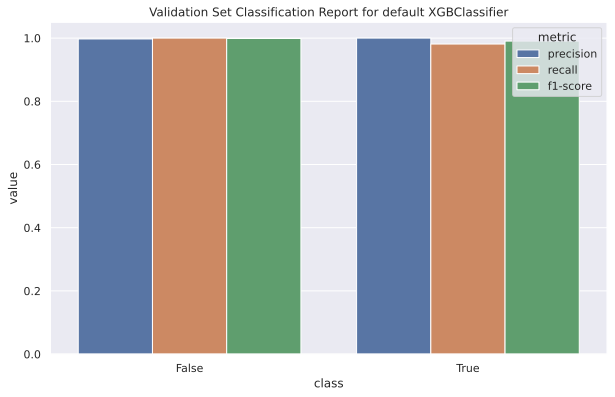

In [ ]:
# Build thee plot for val report
plot_classification_report(y_val, y_val_pred_3, 'Validation Set Classification Report for default XGBClassifier')

### 4.2. XGBoost Model with tuned hiperparameters

In [ ]:
# Set up the parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize new XGBoost classifier
cls_xgb_tuned = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=cls_xgb_tuned, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_xgb = grid_search.best_params_

# Evaluate the best model on the val and test sets
best_clf_xgb_tuned = grid_search.best_estimator_
y_val_pred_4 = best_clf_xgb_tuned.predict(X_val)
val_report_4 = classification_report(y_val, y_val_pred_4, digits=3)

y_test_pred_4 = best_clf_xgb_tuned.predict(X_test)
test_report_4 = classification_report(y_test, y_test_pred_4, digits=3)

print("Best Parameters:\n", best_params_xgb)
print("Validation Report:\n", val_report_4)
print("Test Report:\n", test_report_4)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters:
 {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.6}
Validation Report:
               precision    recall  f1-score   support

       False      0.997     1.000     0.999       355
        True      1.000     0.981     0.990        53

    accuracy                          0.998       408
   macro avg      0.999     0.991     0.995       408
weighted avg      0.998     0.998     0.998       408

Test Report:
               precision    recall  f1-score   support

       False      0.994     1.000     0.997       179
        True      1.000     0.962     0.980        26

    accuracy                          0.995       205
   macro avg      0.997     0.981     0.989       205
weighted avg      0.995     0.995     0.995       205



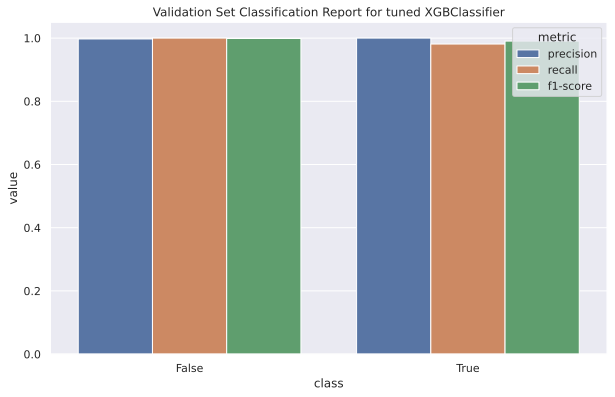

In [ ]:
plot_classification_report(y_val, y_val_pred_4, 'Validation Set Classification Report for tuned XGBClassifier')

### 4.3. Show Feature Importances of the XGBoost Model

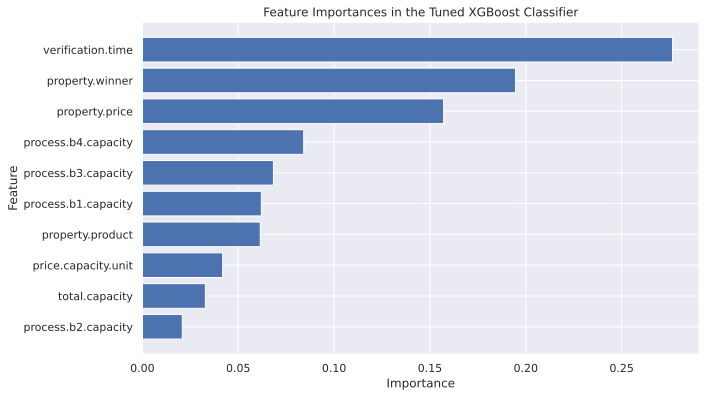

In [ ]:
importance_4 = best_clf_xgb_tuned.feature_importances_
feature_names = X.columns

# Create pandas frame for visualization
feature_importances_4 = pd.DataFrame({'Feature': feature_names, 'Importance': importance_4})
feature_importances_4 = feature_importances_4.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_4['Feature'], feature_importances_4['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in the Tuned XGBoost Classifier')
plt.gca().invert_yaxis()
plt.show()

## **5. Build Stacking Model**

### 5.1. Default Models

In [ ]:
# Define base models - default parameters
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
]

In [ ]:
# Create meta-features array
meta_features_train = np.zeros((X_train.shape[0], len(base_models)))
meta_features_val = np.zeros((X_val.shape[0], len(base_models)))

# Train base models and generate meta-features
for i, (name, model) in enumerate(base_models):
    model.fit(X_train, y_train)
    meta_features_train[:, i] = model.predict(X_train)
    meta_features_val[:, i] = model.predict(X_val)

# Train meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_features_train, y_train)

# Make final predictions
final_predictions_5 = meta_model.predict(meta_features_val)

# Evaluate the model
accuracy = accuracy_score(y_val, final_predictions_5)
val_report_5 = classification_report(y_val, final_predictions_5, digits=3)
conf_matrix_5 = confusion_matrix(y_val, final_predictions_5)

print("Validation Report:\n", val_report_5)

Validation Report:
               precision    recall  f1-score   support

       False      0.994     1.000     0.997       355
        True      1.000     0.962     0.981        53

    accuracy                          0.995       408
   macro avg      0.997     0.981     0.989       408
weighted avg      0.995     0.995     0.995       408



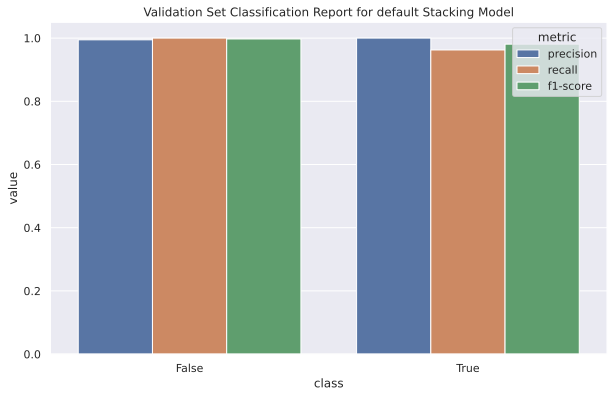

In [ ]:
# Build thee plot for val report
plot_classification_report(y_val, final_predictions_5, 'Validation Set Classification Report for default Stacking Model')

### 5.2. Tuned Models

In [ ]:
# # Set up the parameter grid
param_grids_stack = {
    'rf': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'gb': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly']
    }
}

In [ ]:
# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
]

In [ ]:
# Train models with GridSearchCV
best_models = {}
for name, model in base_models:
    grid_search_stack = GridSearchCV(estimator=model, param_grid=param_grids_stack[name], cv=3, n_jobs=-1, verbose=2)
    grid_search_stack.fit(X_train, y_train)
    best_models[name] = grid_search_stack.best_estimator_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [ ]:
# Create meta-features for training and validation sets and make intermediary predictions
meta_features_train = np.column_stack([best_models[name].predict(X_train) for name, _ in base_models])
meta_features_val = np.column_stack([best_models[name].predict(X_val) for name, _ in base_models])

# Train meta-model
meta_model_tuned = LogisticRegression(random_state=42)
meta_model_tuned.fit(meta_features_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# Evaluate on validation set
y_val_pred_6 = meta_model.predict(meta_features_val)
val_report_6 = classification_report(y_val, y_val_pred_6, digits=3)


# Make final predictions
meta_features_test = np.column_stack([best_models[name].predict(X_test) for name, _ in base_models])
final_predictions_6 = meta_model_tuned.predict(meta_features_test)

# Evaluate the model on test set
test_report_6 = classification_report(y_test, final_predictions_6, digits=3)

# Print the results
print("Validation Report:\n", val_report_6)
print("Test Report:\n", test_report_6)

Validation Report:
               precision    recall  f1-score   support

       False      0.997     1.000     0.999       355
        True      1.000     0.981     0.990        53

    accuracy                          0.998       408
   macro avg      0.999     0.991     0.995       408
weighted avg      0.998     0.998     0.998       408

Test Report:
               precision    recall  f1-score   support

       False      0.994     1.000     0.997       179
        True      1.000     0.962     0.980        26

    accuracy                          0.995       205
   macro avg      0.997     0.981     0.989       205
weighted avg      0.995     0.995     0.995       205



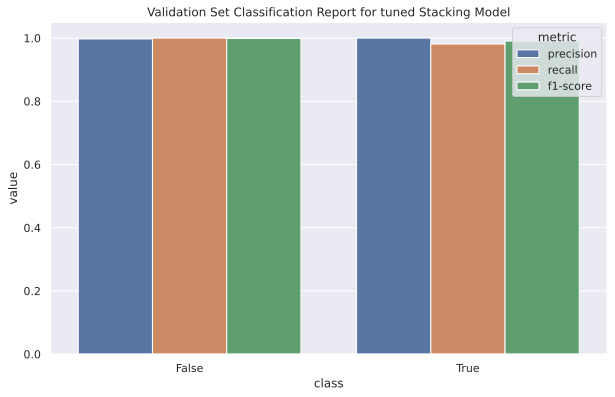

In [ ]:
plot_classification_report(y_val, y_val_pred_6, 'Validation Set Classification Report for tuned Stacking Model')

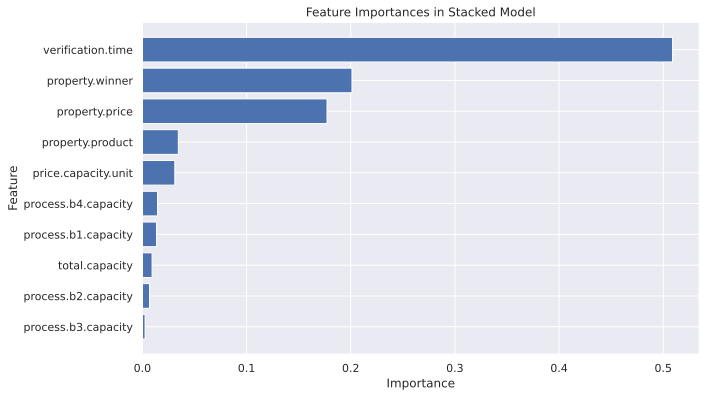

In [ ]:
# Get feature importances
importance_5 = np.mean([model.feature_importances_ for name, model in best_models.items() if hasattr(model, 'feature_importances_')], axis=0)
feature_names = X.columns

# Create a pandas frame for visualization
feature_importances_5 = pd.DataFrame({'Feature': feature_names, 'Importance': importance_5})
feature_importances_5 = feature_importances_5.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_5['Feature'], feature_importances_5['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Stacked Model')
plt.gca().invert_yaxis()
plt.show()

Середні значення feature importances взяті зі всіх бейз моделей Стеку

Як висновок можна зазначити, що стекінг та бустінг показали найкращі результати і їх метрики практично однакові навіть на тестовому датасеті. Проблема в тому що в нас замало даних в тестовмоу датасеті.